In [4]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [5]:
import numpy as np
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## --- Num:  4  --- ##


0  # ------- block_n_layers:  1  ------- #


Epoch [0/30], Loss: 3.2940, Loss validation: 2.9532
	 Validation string, 	 i: 0; 	 prediction: 0.1825, 	 target: 0.1937, 	 loss: 0.0578
	 Validation string, 	 i: 1; 	 prediction: -0.0421, 	 target: -0.0674, 	 loss: 0.3757
	 Validation string, 	 i: 2; 	 prediction: -0.0559, 	 target: -0.0992, 	 loss: 0.4365
Epoch [1/30], Loss: 0.9271, Loss validation: 0.7113, Time remaining: ~0.0h 2.0m 35s
	 Validation string, 	 i: 0; 	 prediction: 0.1789, 	 target: 0.1937, 	 loss: 0.0763
	 Validation string, 	 i: 1; 	 prediction: -0.0573, 	 target: -0.0674, 	 loss: 0.1505
	 Validation string, 	 i: 2; 	 prediction: -0.0251, 	 target: -0.0992, 	 loss: 0.7475
Epoch [2/30], Loss: 0.6229, Loss validation: 0.6818, Time remaining: ~0.0h 2.0m 21s
	 Validation string, 	 i: 0; 	 prediction: 0.1925, 	 target: 0.1937, 	 loss: 0.0063
	 Validation string, 	 i: 1; 	 prediction: -0.0654, 	 target: -0.0674, 	 loss: 0.0301
	 Validation string, 	 i: 2;

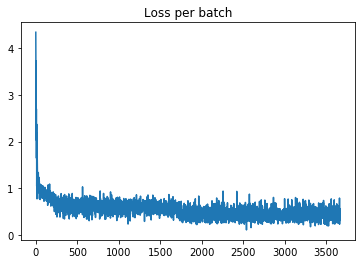

Saved in:  peptide-QML/checkpoints/0901/plots/0901-4h_em_1qm_losses_epochs_4.png


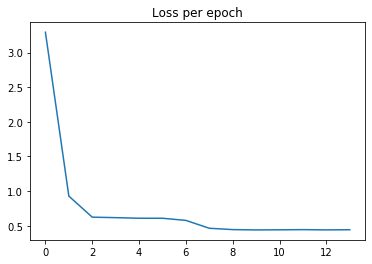

Saved in:  peptide-QML/checkpoints/0901/plots/0901-4h_em_1qm_losses_epochs_validation_4.png


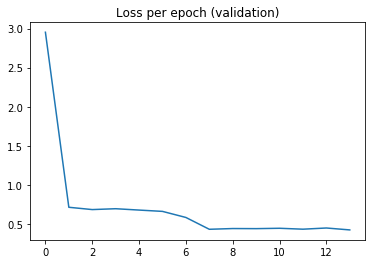

Saved in:  peptide-QML/checkpoints/0901/txts/0901-4h_em_1qm_losses_batches_4.txt
Saved in:  peptide-QML/checkpoints/0901/txts/0901-4h_em_1qm_losses_epochs_4.txt
Saved in:  peptide-QML/checkpoints/0901/txts/0901-4h_em_1qm_losses_epochs_validation_4.txt
Model saved as peptide-QML/checkpoints/0901/models/0901-4h_em_1qm_4.pth
Saved in:  peptide-QML/checkpoints/0901/plots/0901-4h_em_1qm_validation_4.png


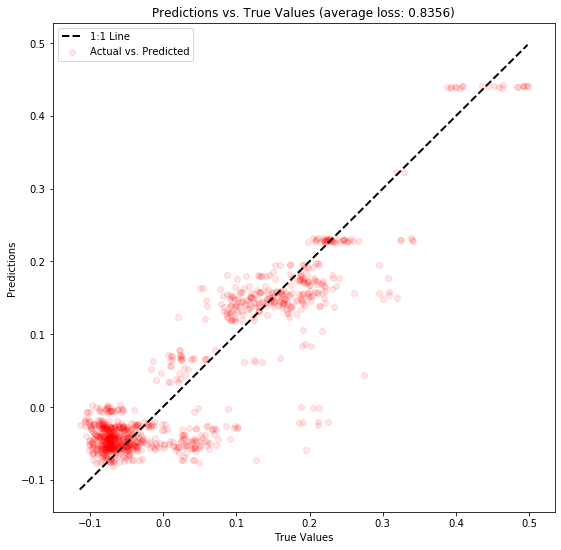

Saved in:  peptide-QML/checkpoints/0901/txts/0901-4h_em_1qm_validation_4.txt
0  # ------- block_n_layers:  3  ------- #


Epoch [0/30], Loss: 3.6300, Loss validation: 3.4940
	 Validation string, 	 i: 0; 	 prediction: 0.1776, 	 target: 0.1937, 	 loss: 0.0833
	 Validation string, 	 i: 1; 	 prediction: -0.0710, 	 target: -0.0674, 	 loss: 0.0532
	 Validation string, 	 i: 2; 	 prediction: -0.0363, 	 target: -0.0992, 	 loss: 0.6339
Epoch [1/30], Loss: 0.9158, Loss validation: 0.7195, Time remaining: ~0.0h 4.0m 31s
	 Validation string, 	 i: 0; 	 prediction: 0.1866, 	 target: 0.1937, 	 loss: 0.0365
	 Validation string, 	 i: 1; 	 prediction: -0.0759, 	 target: -0.0674, 	 loss: 0.1249
	 Validation string, 	 i: 2; 	 prediction: -0.0596, 	 target: -0.0992, 	 loss: 0.3991
Epoch [2/30], Loss: 0.6333, Loss validation: 0.7204, Time remaining: ~0.0h 4.0m 5s
	 Validation string, 	 i: 0; 	 prediction: 0.1783, 	 target: 0.1937, 	 loss: 0.0794
	 Validation string, 	 i: 1; 	 prediction: -0.0504, 	 target: -

In [6]:
# for num in [4, 6, 8, 10, 12]:
for num in [4, 6]:
    print("## --- Num: ", num, " --- ##")
    print("")
    print("")

    for type_energy in ['', '_Single', '_Pair']:

        # -- DATA -- #

        # name of the notebook
        day = "0901"
        name_notebook = "{}-{}h_em_1qm{}.ipynb".format(day, num, type_energy)
        # save the name of the notebook
        with open('{}_notebooks_names.txt'.format(day), 'a') as file:
            file.write(name_notebook + '\n')

        # load data
        data_file_path = '{}data/Scores/PET/generated/bb14_Strings_Energies{}_10_000_{}_aa.txt'.format(initial_path, type_energy, num)  
        string_list, number_list = f.read_data_file(data_file_path)
        score_list = np.array(number_list)/1000
        vector_list = np.array([f.string_to_numbers(string) for string in string_list]) 
        X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

        # Define the dataset
        input_data = ptm.torch.tensor(X) 
        target_data = ptm.torch.tensor(Y).view(-1, 1)

        # Define the validation set
        input_validation = ptm.torch.tensor(X_validation)
        target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)


        # -- TRAINING LOOP -- #
        for iii in range(5):

            for block_n_layers in range(1, 21, 2):
                print(iii, " # ------- block_n_layers: ", block_n_layers, " ------- #")
                print("")
                print("")

                # -- QUANTUM NODE -- #

                n_aminoacids = len(string_list[0])

                quantum_layer = qn.circuit(
                    n_qubits = n_aminoacids, 
                    device = "default.qubit.torch",
                    device_options = {'shots': None},
                    embedding = qn.parts.AngleEmbedding, 
                    # embedding_ansatz = qn.parts.Ansatz_11,
                    block_ansatz = qn.parts.Ansatz_11,
                    final_ansatz = qn.parts.Ansatz_final_11,
                    measurement = qn.parts.Measurement('Z', (n_aminoacids-1)//2),
                    # embedding_n_layers = 4,
                    # different_inputs_per_layer = True,
                    block_n_layers = block_n_layers,
                    # wrapper_qlayer = pw.QLayerEmpty,
                )

                # -- HYBRID MODEL -- #
                input_dim = input_data.size(1)

                n_pre_classical_layers = 4
                layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

                import torch.nn as nn
                import torch
                    
                class Reshape(nn.Module):
                    def __init__(self):
                        super(Reshape, self).__init__()

                    def forward(self, x):
                        dims = len(x.shape)
                        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

                layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
                layers += [quantum_layer(), ptm.nn.Linear(1,1)]

                # Create model and set data:
                model = ptm.pytorch_model(
                    layers,    
                    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
                )
                model.set_data(
                    data_X=input_data, 
                    data_Y=target_data, 
                    data_X_validation=input_validation,
                    data_Y_validation=target_validation
                )
                model.keep_track_params=False


                # -- TRAINING -- #
                import torch.optim as optim

                # train the model
                model.train(
                    optimizer= optim.Adam,
                    optimizer_options={'lr': 0.01},
                    num_epochs = 30,                
                    batch_size = 32,
                    stop_training_options = {
                        'lookback_epochs': 5, 
                        'threshold_slope': 0,
                        'threshold_std_dev': 0.2
                    },
                )

                # -- SAVE -- #

                # dump the object
                model.dump()

                # save string of the model
                model.save_str(
                    metadata={
                        "data_file_path": data_file_path,
                        "Quantum_circuit": quantum_layer.__str__(),
                    }
                )

                # plot the losses of the trainig loop and save the figures
                model.plot_losses(save=True, save_txt=True)

                #save all the parameters of the model and the intermediate parameters of the model
                model.save_state_dict(intermediate=False)

                # plot the validation and save it
                model.plot_validation(save=True, fig_size=(9,9), percentatge=1)

                # print validation and save it
                model.str_validation(save=True, precision=4, percentatge=1, printing=False)

In [ ]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push